


# PyTorch Basics

I'll assume that everyone is familiar with Python. Training neural nets in bare Python is somewhat painful, but fortunately there are several well-established libraries which can help. I like PyTorch, which is built upon an earlier library called Torch. (There are many others, including TensorFlow and Jax, both of which I would encourage you to explore at your leisure.)


In [ ]:
import numpy as np
import torch
import torchvision

Torch believes that everything is a *tensor*.

In [ ]:
a = np.random.rand(2,3)
b = torch.from_numpy(a)

print(a)
print(b)

[[0.36886509 0.71902655 0.21237602]
 [0.08664056 0.92586243 0.75731764]]
tensor([[0.3689, 0.7190, 0.2124],
        [0.0866, 0.9259, 0.7573]], dtype=torch.float64)


The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon we will see that training neural nets basically involves *forward* and *backward* passes, both of which are essentially matrix multiplies.

The other thing about Torch variables is that they (natively) can be differentiated. (Again, we will see why this is important when we learn about backpropagation in deep learning.) 

In [ ]:
A = torch.rand(2,2)
b = torch.rand(2,1)
x = torch.rand(2,1,requires_grad=True)

y = torch.matmul(A,x) + b

print(y)

tensor([[1.6215],
        [1.5528]], grad_fn=<AddBackward0>)


In [ ]:
z = y.sum()
print(z)

tensor(3.1743, grad_fn=<SumBackward0>)


Here, *z* is a function of the input *x*. Let us now compute the derivative of *z* with respect to *x* using backpropagation.

In [ ]:
z.backward()
print(x.grad)
print(x)

tensor([[1.4711],
        [1.1740]])
tensor([[0.8120],
        [0.8263]], requires_grad=True)


# Training simple models

OK, enough background. Let us now train a simple model. We will train a logistic classifier (equivalent to a single-layer neural network) on a popular image dataset called *Fashion-MNIST*. (TorchVision has several other image datasets which we can directly load as variables, feel free to train your own models on them). 

In [ ]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Let's quickly check that everything has been downloaded.

In [ ]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Some of you might know that this is the same size as the (very commonly used) MNIST dataset. Let's plot some images.

In [ ]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the 'image' object since it is a Torch tensor, so let's convert it back into a numpy array before displaying it. We will use matplotlib to show images.

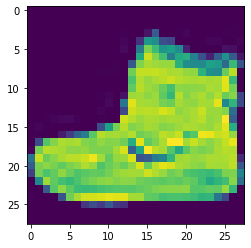

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze().numpy())
plt.show()

OK, that kinda sorta looks like a shoe? FashionMNIST is basically a bunch of black-white thumbnail images of different pieces of clothing. Let's try and plot a few of them. To step through the dataset, it will be helpful to construct a *data loader* object; we will use this while training our model below as well.

In [ ]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

Let's now use the DataLoader object to spit out a few images from the dataset.

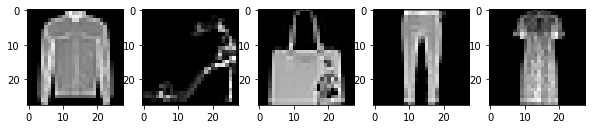

In [ ]:
images, labels = iter(trainDataLoader).next()

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.imshow(images[index].squeeze().numpy(),cmap=plt.cm.gray)

OK! Time to set up our model. 

In [ ]:
class LinearReg(torch.nn.Module):
  def __init__(self):
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28,10)

  def forward(self, x):
    x = x.view(-1,28*28) # view is like reshape function in numpy, x.view(-1,28*28) is switching the shape from(1,28,28) to (28,28)
    transformed_x = self.linear(x)
    return transformed_x

net = LinearReg().cuda()
Loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

Cool! Everything is set up. Let's now train our network.

In [ ]:
train_loss_history = []
test_loss_history = []

for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad() #梯度归零
    predicted_output = net(images) #将图像丢入网络中，得到预测值
    fit = Loss(predicted_output, labels)
    fit.backward()
    optimizer.step()
    train_loss += fit.item()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad(): #在使用pytorch时，并不是所有的操作都需要进行计算图的生成（计算过程的构建，以便梯度反向传播等操作）。而对于tensor的计算操作，默认是要进行计算图的构建的，在这种情况下，可以使用 with torch.no_grad():，强制之后的内容不进行计算图构建。
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      predicted_output = net(images)
      fit = Loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  print("Length:", len(trainDataLoader))
  test_loss = test_loss/ len(testDataLoader)
  print("Length:", len(testDataLoader))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))



Length: 938
Length: 157
Epoch 0, Train loss 0.9624944567235548, Test loss 0.738086311111025
Length: 938
Length: 157
Epoch 1, Train loss 0.6674924275831882, Test loss 0.6471622394528359
Length: 938
Length: 157
Epoch 2, Train loss 0.6034417294744235, Test loss 0.6039617479227151
Length: 938
Length: 157
Epoch 3, Train loss 0.5685348051316195, Test loss 0.578670302014442
Length: 938
Length: 157
Epoch 4, Train loss 0.5460536097412678, Test loss 0.5596255458843936
Length: 938
Length: 157
Epoch 5, Train loss 0.5294107555834724, Test loss 0.5463960130882871
Length: 938
Length: 157
Epoch 6, Train loss 0.516658032181929, Test loss 0.5364546504369967
Length: 938
Length: 157
Epoch 7, Train loss 0.5063999171958549, Test loss 0.532113416749201
Length: 938
Length: 157
Epoch 8, Train loss 0.49814867048756656, Test loss 0.5219381083348754
Length: 938
Length: 157
Epoch 9, Train loss 0.49097243431153326, Test loss 0.515208460912583
Length: 938
Length: 157
Epoch 10, Train loss 0.48486738226243425, Test lo

Let's see how we did! We have tracked the losses so let's plot it.

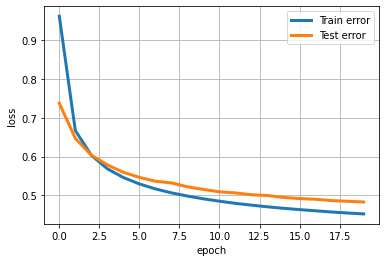

In [ ]:
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

Not too bad (although more epochs would have helped, I suppose). Let's evaluate our final model on a few more images to wrap things up.

In [ ]:
predicted_output = net(images) # last batch of images
print(torch.max(predicted_output,1)) #2.函数输出torch.max(input, dim=1),此函数输出两个tensor,1.第一个tensor是每行的最大概率2.第二个tensor是每行最大概率的索引,由于我们不需要获取最大概率的值，只要知道最大概率的是哪个类别即可,因此，我们只需要获取第二个tensor
fit = Loss(predicted_output, labels)
print(labels)
print(fit)

torch.return_types.max(
values=tensor([ 6.2009,  3.1517,  8.8959,  7.8950,  6.5635,  6.1154, 10.2651,  4.4709,
         6.9733, 11.6389, 10.5157, 10.4670,  6.7165,  4.4769,  9.3497,  4.5495],
       device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 7, 5, 8, 2, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0'))
tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5], device='cuda:0')
tensor(0.3162, device='cuda:0', grad_fn=<NllLossBackward0>)


Cool, looks like 2 images in this batch are being misclassified; can you (as a human) guess what those are?

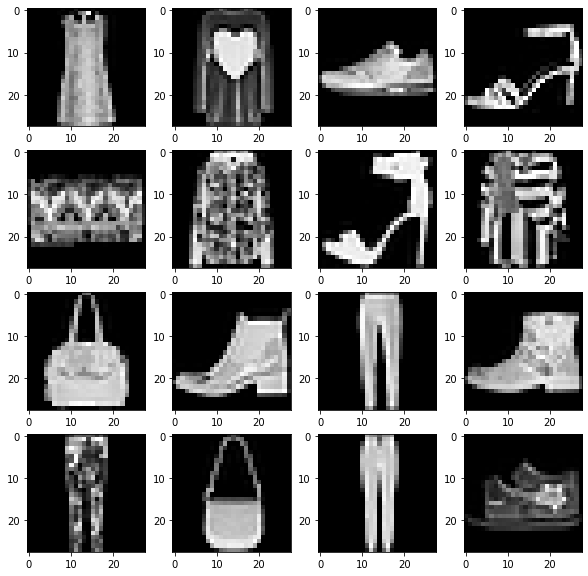

In [ ]:
plt.figure(figsize=(10,10))
for index in np.arange(0,16):
  plt.subplot(4,4,index+1)
  plt.imshow(images[index].cpu().squeeze().numpy(),cmap=plt.cm.gray)